# Freezing Parameters in Optax

This guide demonstrates multiple methods to freeze (i.e. hold constant) subsets of your model's parameters during optimization with Optax. Optax provides ways to do this via `optax.transforms.freeze` and `optax.transforms.selective_transform`, and from-scratch methods using `optax.set_to_zero()`, `optax.masked`, `optax.partition`.

Below, we first show the new recommended utilities, then provide the classic (from-scratch) approaches for reference.

In [1]:
# Import libraries
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

from optax import transforms
freeze = transforms.freeze
selective_transform = transforms.selective_transform

For all examples, our goal is to minimize the absolute sum of param0 and param1.
So our loss function becomes:

In [2]:
def loss_fn(p):
    return jnp.abs(p["param0"][0]) + jnp.abs(p["param1"][0])

### 1. Freezing with `optax.transforms.freeze`

The new `optax.transforms.freeze` utility provides a simple way to freeze parameters using a mask. This is equivalent to the classic masked approach, but uses the new helper.

> **Comment:** Uses `optax.chain(optax.adam, freeze(mask))` to freeze parameters marked `True` in the mask.

In [3]:
# Initialize parameters and mask
params = {
    "param0": jnp.array([10.0]),  # will be trained
    "param1": jnp.array([10.0]),  # will be frozen
}
mask = {"param0": False, "param1": True}

# Create optimizer with freeze utility
optimizer = optax.chain(optax.adam(0.1), freeze(mask))
opt_state = optimizer.init(params)

# Define a single training step
@jax.jit
def train_step(p, s):
    # Compute loss and gradients
    loss, grads = jax.value_and_grad(loss_fn)(p)
    # Update parameters using optimizer
    updates, s = optimizer.update(grads, s, p)
    new_p = optax.apply_updates(p, updates)
    return new_p, s, loss

# Initialize history lists to track progress
loss_history = []
param0_history = []
param1_history = []

# Training loop
for i in range(1, 201):
    # Perform a training step
    params, opt_state, loss = train_step(params, opt_state)
    # Record loss and parameter values
    loss_history.append(loss)
    param0_history.append(params["param0"][0])
    param1_history.append(params["param1"][0])
    # Print progress every 50 steps
    if i % 50 == 0:
        print(f"Step {i:>3d}  loss={loss:.4f}  param0={params['param0'][0]:.4f}  param1={params['param1'][0]:.4f}")

# Verify that param0 was optimized and param1 stayed frozen
assert not jnp.isclose(params["param0"][0], 10.0)
assert jnp.isclose(params["param1"][0], 10.0)
print("✅ param1 stayed at 10.0; param0 was optimized toward zero.")

Step  50  loss=15.1000  param0=5.0000  param1=10.0000
Step 100  loss=10.1001  param0=0.0001  param1=10.0000
Step 150  loss=10.0415  param0=0.0274  param1=10.0000
Step 200  loss=10.0060  param0=-0.0246  param1=10.0000
✅ param1 stayed at 10.0; param0 was optimized toward zero.


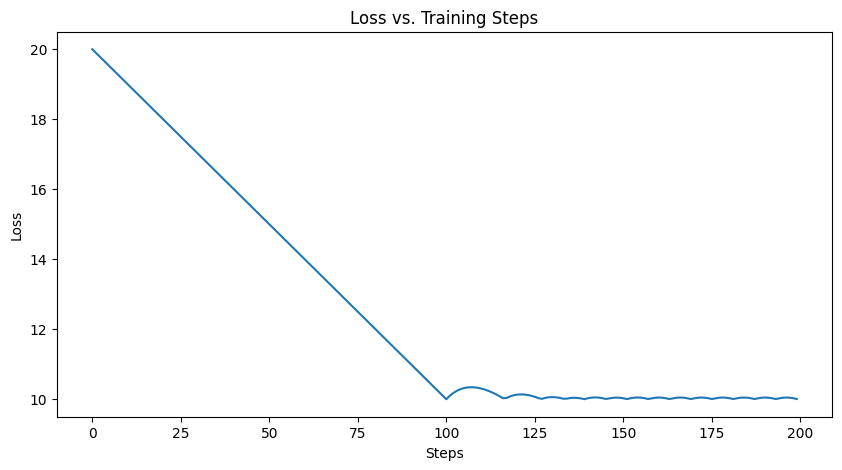

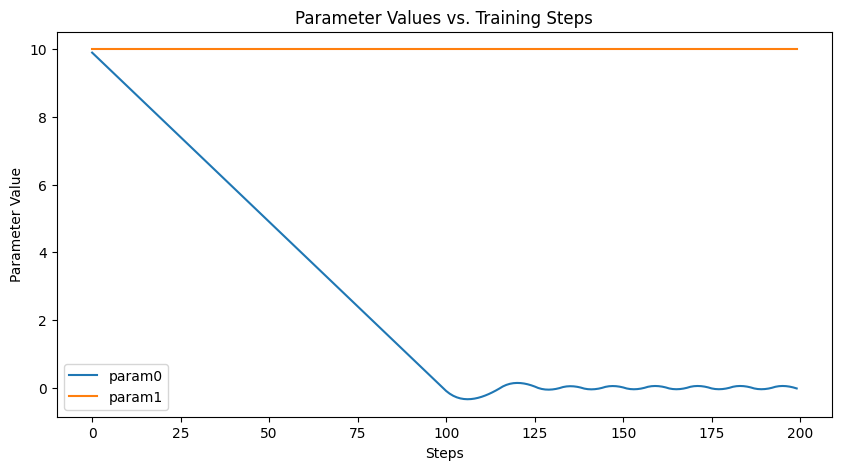

In [4]:
# Plot loss vs. steps
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Loss vs. Training Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

# Plot parameter values vs. steps
plt.figure(figsize=(10, 5))
plt.plot(param0_history, label="param0")
plt.plot(param1_history, label="param1")
plt.title("Parameter Values vs. Training Steps")
plt.xlabel("Steps")
plt.ylabel("Parameter Value")
plt.legend()
plt.show()

### 2. Freezing with `optax.transforms.selective_transform`

The new `optax.transforms.selective_transform` utility lets you apply an optimizer only to unfrozen parameters, using a mask. This is a more concise and robust way to freeze parameters than using `partition` directly.

> **Comment:** Uses `selective_transform(optax.adam, mask)` to freeze parameters marked `True` in the mask.

In [5]:
# Initialize parameters and mask
params = {
    "param0": jnp.array([10.0]),  # will be trained
    "param1": jnp.array([10.0]),  # will be frozen
}
mask = {"param0": False, "param1": True}

# Create optimizer with selective_transform utility
optimizer = selective_transform(optax.adam(0.1), freeze_mask=mask)
opt_state = optimizer.init(params)

# Define a single training step
@jax.jit
def train_step(p, s):
    # Compute loss and gradients
    loss, grads = jax.value_and_grad(loss_fn)(p)
    # Update parameters using optimizer
    updates, s = optimizer.update(grads, s, p)
    new_p = optax.apply_updates(p, updates)
    return new_p, s, loss

# Initialize history lists to track progress
loss_history = []
param0_history = []
param1_history = []

# Training loop
for i in range(1, 201):
    # Perform a training step
    params, opt_state, loss = train_step(params, opt_state)
    # Record loss and parameter values
    loss_history.append(loss)
    param0_history.append(params["param0"][0])
    param1_history.append(params["param1"][0])
    # Print progress every 50 steps
    if i % 50 == 0:
        print(f"Step {i:>3d}  loss={loss:.4f}  param0={params['param0'][0]:.4f}  param1={params['param1'][0]:.4f}")

# Verify that param0 was optimized and param1 stayed frozen
assert not jnp.isclose(params["param0"][0], 10.0)
assert jnp.isclose(params["param1"][0], 10.0)
print("✅ param1 stayed at 10.0; param0 was optimized toward zero.")

Step  50  loss=15.1000  param0=5.0000  param1=10.0000
Step 100  loss=10.1001  param0=0.0001  param1=10.0000
Step 150  loss=10.0415  param0=0.0274  param1=10.0000
Step 200  loss=10.0060  param0=-0.0246  param1=10.0000
✅ param1 stayed at 10.0; param0 was optimized toward zero.


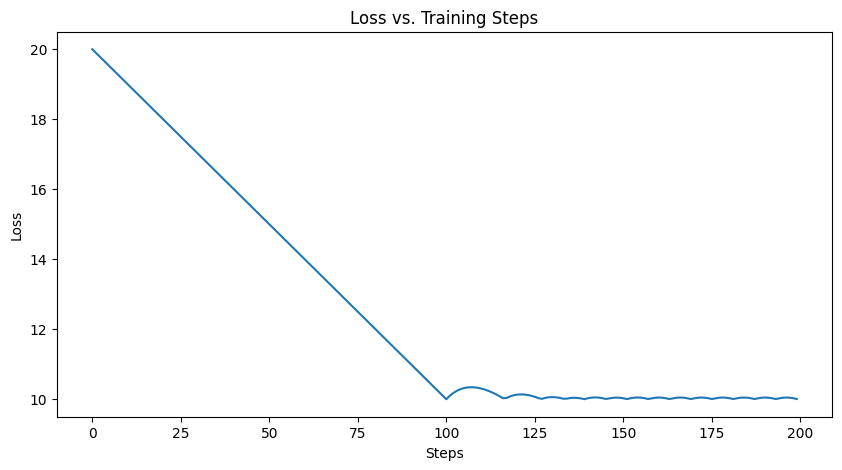

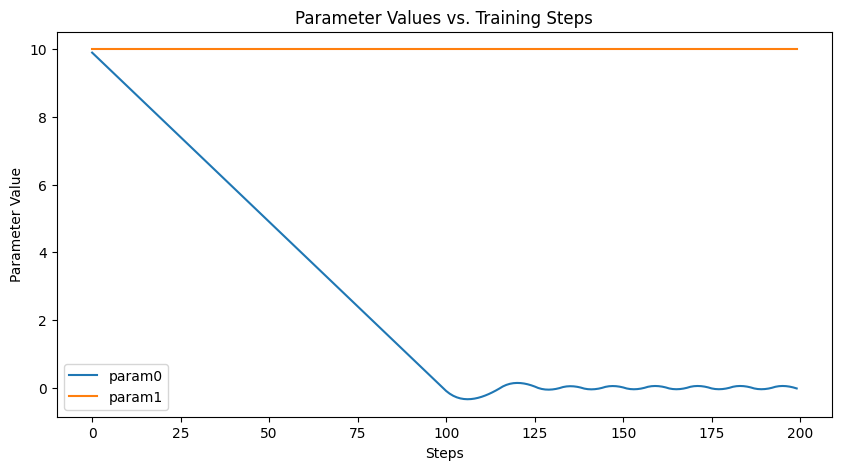

In [6]:
# Plot loss vs. steps
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Loss vs. Training Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

# Plot parameter values vs. steps
plt.figure(figsize=(10, 5))
plt.plot(param0_history, label="param0")
plt.plot(param1_history, label="param1")
plt.title("Parameter Values vs. Training Steps")
plt.xlabel("Steps")
plt.ylabel("Parameter Value")
plt.legend()
plt.show()

### 3. Dynamic Freezing/Unfreezing with `selective_transform`

You can dynamically swap which parameters are frozen by re-creating the optimizer with a new mask. This example starts with `param0` trainable and `param1` frozen, then swaps at step 200.

> **Comment:** Demonstrates dynamic freezing/unfreezing by changing the mask and re-initializing the optimizer.

In [7]:
# Initialize parameters and mask
params = {"param0": jnp.array([10.0]), "param1": jnp.array([10.0])}
mask = {"param0": False, "param1": True}

# Create optimizer with selective_transform utility
optimizer = selective_transform(optax.adam(0.1), freeze_mask=mask)
opt_state = optimizer.init(params)

# Initialize history lists to track progress
loss_history = []
param0_history = []
param1_history = []

# Training loop with dynamic mask swap at step 200
for step in range(1, 401):
    # At step 200, swap which parameter is frozen
    if step == 200:
        mask = {"param0": True, "param1": False}
        optimizer = selective_transform(optax.adam(0.1), freeze_mask=mask)
        opt_state = optimizer.init(params)  # ⚠️ resets optimizer state

    # Compute loss and gradients
    loss, grads = jax.value_and_grad(loss_fn)(params)

    # Update parameters using optimizer
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    # Record loss and parameter values
    loss_history.append(loss)
    param0_history.append(params["param0"][0])
    param1_history.append(params["param1"][0])

    # Print progress every 100 steps
    if step % 100 == 0:
        print(f"Step {step:3d}  loss={loss:.4f}  param0={params['param0'][0]:.4f}  param1={params['param1'][0]:.4f}")

# Verify that param0 reached near zero and param1 was updated
assert jnp.isclose(params["param0"][0], 0.0, atol=1e-2)
assert params["param1"][0] != 10.0
print("✅ Dynamic swap worked param0: train→frozen, param1: frozen→train")

Step 100  loss=10.1001  param0=0.0001  param1=10.0000
Step 200  loss=10.0060  param0=0.0060  param1=9.9000
Step 300  loss=0.0061  param0=0.0060  param1=-0.0999
Step 400  loss=0.0306  param0=0.0060  param1=-0.0421
✅ Dynamic swap worked param0: train→frozen, param1: frozen→train


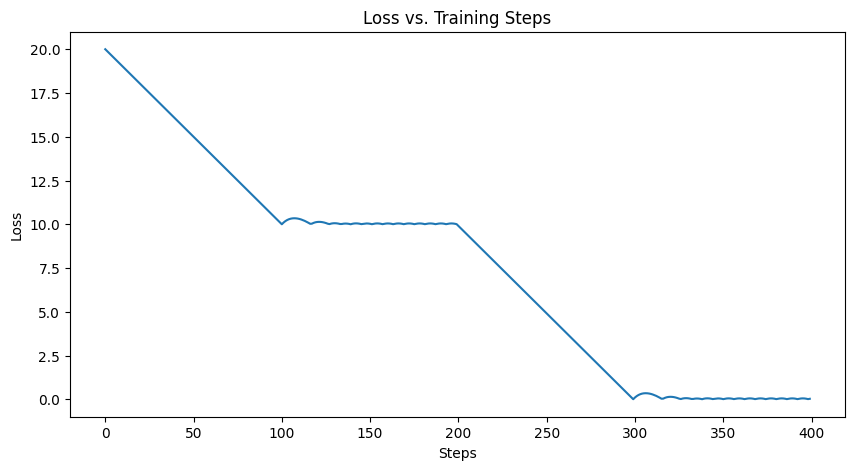

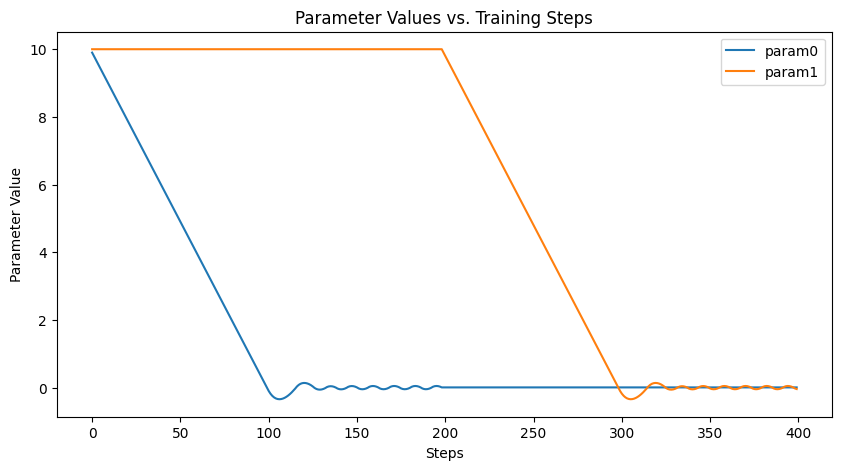

In [8]:
# Plot loss vs. steps
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Loss vs. Training Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

# Plot parameter values vs. steps
plt.figure(figsize=(10, 5))
plt.plot(param0_history, label="param0")
plt.plot(param1_history, label="param1")
plt.title("Parameter Values vs. Training Steps")
plt.xlabel("Steps")
plt.ylabel("Parameter Value")
plt.legend()
plt.show()

# From-scratch Implementation

The following sections show the classic approaches for freezing parameters in Optax, for reference.

### 1. Simple Masked Freezing (True = freeze, False = train)

Use `optax.masked` together with `optax.set_to_zero()` to prevent updates to any parameters marked `True` in the mask. In the snippet below, we freeze `param1` (mask=True) and train `param0` (mask=False) using Adam.

> **Comment:** Uses `optax.chain(optax.adam, optax.masked(optax.set_to_zero(), mask))` to freeze parameters.

In [9]:
# Define two scalar “parameters”
params = {
    "param0": jnp.array([10.0]),  # will be trained
    "param1": jnp.array([10.0]),  # will be frozen
}

# Build a mask: False → train, True → freeze
mask = {"param0": False, "param1": True}

# Create optimizer: Adam + masked(set_to_zero)
optimizer = optax.chain(optax.adam(0.1), optax.masked(optax.set_to_zero(), mask))
opt_state = optimizer.init(params)


# training step
@jax.jit
def train_step(p, s):
    loss, grads = jax.value_and_grad(loss_fn)(p)
    updates, s = optimizer.update(grads, s, p)
    new_p = optax.apply_updates(p, updates)
    return new_p, s, loss


# Initialize lists to store loss and parameter values
loss_history = []
param0_history = []
param1_history = []

# Run 200 steps to verify
for i in range(1, 201):
    params, opt_state, loss = train_step(params, opt_state)
    loss_history.append(loss)
    param0_history.append(params["param0"][0])
    param1_history.append(params["param1"][0])
    if i % 50 == 0:
        print(
            f"Step {i:>3d}  loss={loss:.4f}  "
            f"param0={params['param0'][0]:.4f}  "
            f"param1={params['param1'][0]:.4f}"
        )

# Verify freezing
assert not jnp.isclose(params["param0"][0], 10.0), "param0 should have moved"
assert jnp.isclose(params["param1"][0], 10.0), "param1 should remain frozen"
print("✅ param1 stayed at 10.0; param0 was optimized toward zero.")


Step  50  loss=15.1000  param0=5.0000  param1=10.0000
Step 100  loss=10.1001  param0=0.0001  param1=10.0000
Step 150  loss=10.0415  param0=0.0274  param1=10.0000
Step 200  loss=10.0060  param0=-0.0246  param1=10.0000
✅ param1 stayed at 10.0; param0 was optimized toward zero.


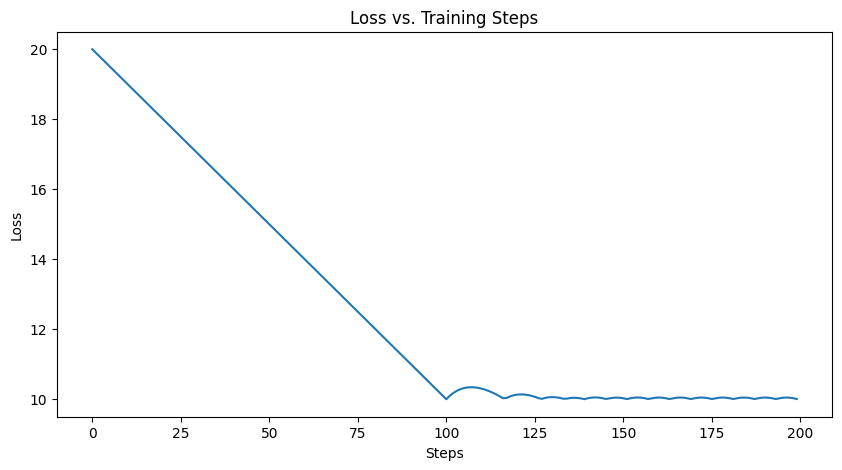

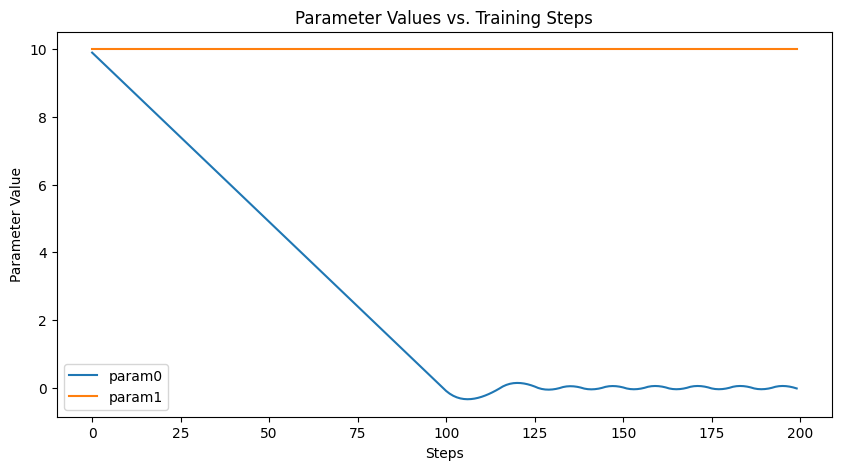

In [10]:
# Plot loss vs. steps
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Loss vs. Training Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

# Plot parameter values vs. steps
plt.figure(figsize=(10, 5))
plt.plot(param0_history, label="param0")
plt.plot(param1_history, label="param1")
plt.title("Parameter Values vs. Training Steps")
plt.xlabel("Steps")
plt.ylabel("Parameter Value")
plt.legend()
plt.show()

### 2. Freezing with `optax.partition`

Use `optax.partition` to assign different update rules to each parameter. In this example, we apply Adam to `param0` and completely freeze `param1` by sending it through `optax.set_to_zero()`.

> **Comment:** Uses `optax.partition` to assign Adam or zero update to each parameter.

In [11]:
# Create two scalar “parameters”
params = {
    "param0": jnp.array([10.0]),  # will be trained
    "param1": jnp.array([10.0]),  # will be frozen
}

# Define two transforms: 'train' → Adam, 'freeze' → zero
transforms = {"train": optax.adam(0.1), "freeze": optax.set_to_zero()}

# Map each param name to one of the transforms
label_map = {"param0": "train", "param1": "freeze"}

# Build and initialize the optimizer using partition
optimizer = optax.partition(transforms, label_map)
opt_state = optimizer.init(params)


# JIT‑compiled training step
@jax.jit
def train_step(p, s):
    loss, grads = jax.value_and_grad(loss_fn)(p)
    updates, s = optimizer.update(grads, s, p)
    new_p = optax.apply_updates(p, updates)
    return new_p, s, loss


# Run a few steps and record history
loss_history = []
param0_history = []
param1_history = []

for step in range(1, 201):
    params, opt_state, loss = train_step(params, opt_state)
    loss_history.append(loss)
    param0_history.append(params["param0"][0])
    param1_history.append(params["param1"][0])
    if step % 50 == 0:
        print(
            f"Step {step:3d}  loss={loss:.4f}  "
            f"param0={params['param0'][0]:.4f}  "
            f"param1={params['param1'][0]:.4f}"
        )

# Verify that param1 stayed frozen
assert jnp.isclose(params["param1"][0], 10.0), "param1 should remain unchanged"
print("✅ partition correctly froze param1!")

Step  50  loss=15.1000  param0=5.0000  param1=10.0000
Step 100  loss=10.1001  param0=0.0001  param1=10.0000
Step 150  loss=10.0415  param0=0.0274  param1=10.0000
Step 200  loss=10.0060  param0=-0.0246  param1=10.0000
✅ partition correctly froze param1!


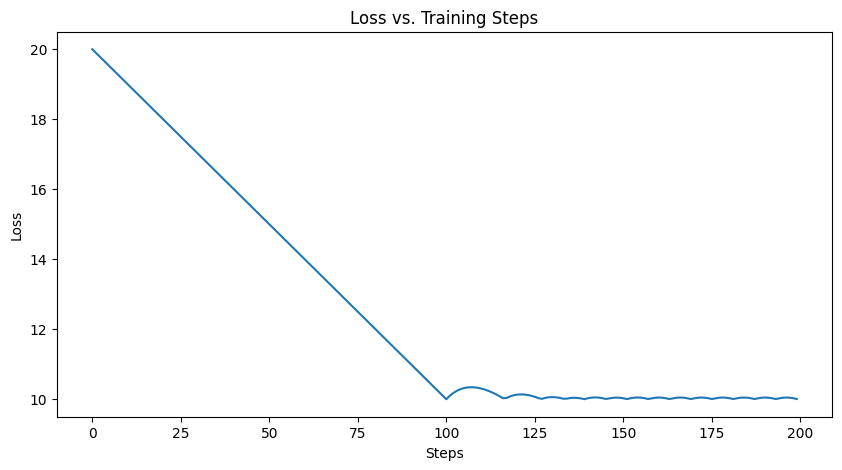

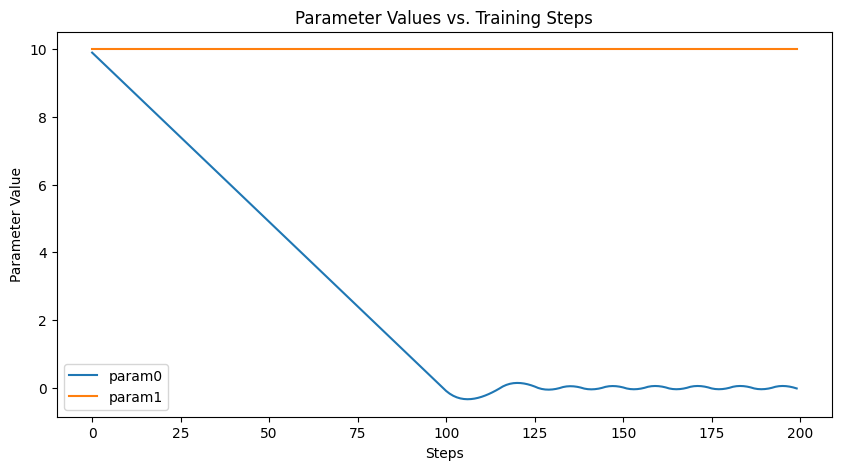

In [12]:
"""This plot will be about the same as the first one"""
# Plot loss vs. steps
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Loss vs. Training Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

# Plot parameters vs. steps
plt.figure(figsize=(10, 5))
plt.plot(param0_history, label="param0")
plt.plot(param1_history, label="param1")
plt.title("Parameter Values vs. Training Steps")
plt.xlabel("Steps")
plt.ylabel("Parameter Value")
plt.legend()
plt.show()

### 3. Dynamic Freeze Scheduling with `optax.partition`

In this example, we start by training `param0` (using Adam) and freezing `param1` (using `set_to_zero`). At step 200, we swap the roles—freezing `param0` and training `param1`—to demonstrate how you can dynamically change which parameters are updated during training.

> **Comment:** Demonstrates dynamic freezing/unfreezing by changing the label map and re-initializing the optimizer.

In [13]:
# Two scalar “params”
params = {
    "param0": jnp.array([10.0]),  # will start trainable
    "param1": jnp.array([10.0]),  # will start frozen
}


# Helper to build optimizer using partition
def make_optimizer(mask):
    return optax.partition({"adam": optax.adam(0.1), "zero": optax.set_to_zero()}, mask)


# Initial mask: train param0, freeze param1
mask = {"param0": "adam", "param1": "zero"}
optimizer = make_optimizer(mask)
opt_state = optimizer.init(params)


# Training loop with dynamic mask swap at step 200
loss_history = []
param0_history = []
param1_history = []

for step in range(1, 401):
    # At step 200, swap which param is frozen
    if step == 200:
        mask = {"param0": "zero", "param1": "adam"}
        optimizer = make_optimizer(mask)
        opt_state = optimizer.init(params)  # ⚠️ resets optimizer state

    # Compute loss and grads
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    # Record history
    loss_history.append(loss)
    param0_history.append(params["param0"][0])
    param1_history.append(params["param1"][0])

    if step % 100 == 0:
        print(
            f"Step {step:3d}  loss={loss:.4f}  "
            f"param0={params['param0'][0]:.4f}  "
            f"param1={params['param1'][0]:.4f}"
        )

# Verify
assert jnp.isclose(params["param0"][0], 0.0, atol=1e-2)
assert params["param1"][0] != 10.0
print("✅ Dynamic swap worked param0: train→frozen, param1: frozen→train")


Step 100  loss=10.1001  param0=0.0001  param1=10.0000
Step 200  loss=10.0060  param0=0.0060  param1=9.9000
Step 300  loss=0.0061  param0=0.0060  param1=-0.0999
Step 400  loss=0.0306  param0=0.0060  param1=-0.0421
✅ Dynamic swap worked param0: train→frozen, param1: frozen→train


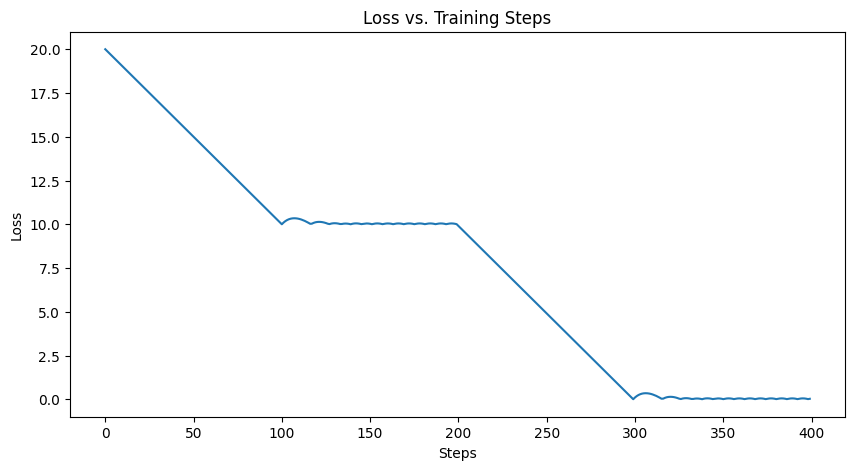

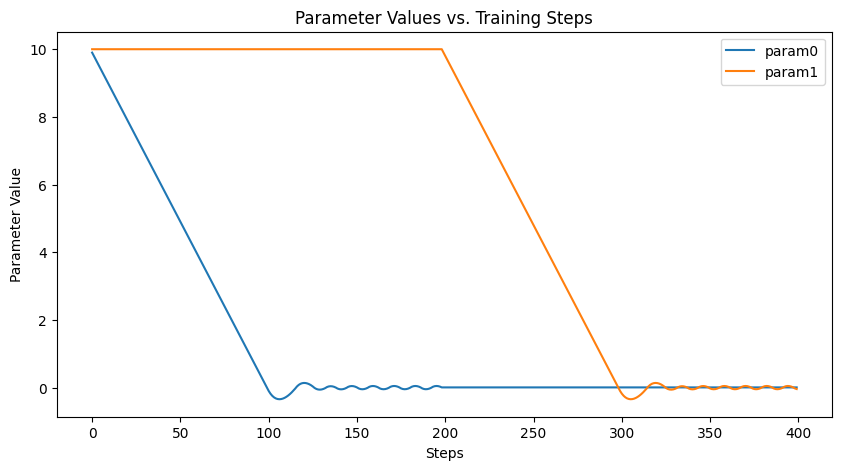

In [14]:
# Plot loss vs. steps
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Loss vs. Training Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

# Plot parameter values vs. steps
plt.figure(figsize=(10, 5))
plt.plot(param0_history, label="param0")
plt.plot(param1_history, label="param1")
plt.title("Parameter Values vs. Training Steps")
plt.xlabel("Steps")
plt.ylabel("Parameter Value")
plt.legend()
plt.show()